# Vamos simular uma estratégia que vai comprar em cada período definido as x% ações com menor retorno nos últimos k dias (No caso simularemos k = 5):

# Primeiro vamos importar os módulos necessários: 

In [1]:
import pandas as pd
import numpy as np 
from pandas_datareader import data as dt
import matplotlib.pyplot as plt

# Vamos importar os dados do yahoo finance: 

In [2]:
tickers = ['ABEV3.SA','LREN3.SA','PETR4.SA','VALE3.SA','PSSA3.SA','POMO4.SA','LAME4.SA','MRFG3.SA','BBAS3.SA','ITUB4.SA'\
              ,'BBDC4.SA','USIM5.SA','BRFS3.SA','CIEL3.SA','CMIG4.SA','GGBR3.SA','CSAN3.SA','SULA11.SA','SBSP3.SA','TOTS3.SA'\
              ,'WEGE3.SA','EGIE3.SA','SANB11.SA','RENT3.SA','HYPE3.SA','DTEX3.SA','FLRY3.SA','MULT3.SA','BRML3.SA','MRVE3.SA'\
              ,'CPFE3.SA','BTOW3.SA','EMBR3.SA','JBSS3.SA','TIMP3.SA','IGTA3.SA','GOLL4.SA','ENBR3.SA','CYRE3.SA','BRAP4.SA'\
              ,'CCRO3.SA','BEEF3.SA']

data = pd.DataFrame()
for i in tickers: 
    data[i]=dt.DataReader(i,data_source='yahoo',start='2010-01-01')['Adj Close']

# Vamos estruturar os dataframes e criar as funções necessárias: 

In [13]:
# Criando uma função que vai pegar só os x% menores de cada linha de um dataframe e inserir pesos iguais para cada valor: 
def filter_pct_smallest(df,pct): 
    n = int(pct*df.count())
    if n>0: 
        smallest_value = df.nsmallest(n)[-1]
        return (df<=smallest_value).astype(int).div((df<=smallest_value).astype(int).sum())
    else: 
        return df

In [66]:
# Vamos montar um dataframe com o retorno dos últimos k dias e agrupado em k dias: 
k = 5

#Dataframe de retornos diários:
data_daily_returns = data.pct_change()

#Dataframe de retorno dos últimos k dias para cada ação: 
data_krolling_returns = data.pct_change(k)

#Dataframe com os retornos dos últimos k dias e agrupado de k em k dias: 
data_krolling_returns_period = data_krolling_returns.iloc[range(0,len(data_krolling_returns),k)]

# Criamos os pesos para a estratégia de mean reversion:

In [67]:
#Dataframe com os pesos de cada ação de k em k dias: 
period_weights_meanreversion = data_krolling_returns_period.apply(filter_pct_smallest,pct=0.3,axis=1)

#Fazendo o dataframe com os pesos diários: 
daily_weights_meanreversion = data_daily_returns.copy()
daily_weights_meanreversion[:]=0
daily_weights_meanreversion.loc[period_weights_meanreversion.index]=period_weights_meanreversion.copy()

for i in range(len(daily_weights_meanreversion)-1):
    if daily_weights_meanreversion.index[i] not in period_weights_meanreversion.index: 
        daily_weights_meanreversion.iloc[i]=daily_weights_meanreversion.iloc[i-1]*(1+data_daily_returns.iloc[i])
        
daily_weights_meanreversion = daily_weights_meanreversion.div(daily_weights_meanreversion.sum(axis=1),axis=0)

# Calculamos os retornos das estratégias e da base: 

In [68]:
# Calculando o retorno da estratégia de mean reversion:
strategy_meanreversion_daily_returns = data_daily_returns.mul(daily_weights_meanreversion.shift(1),axis=1).sum(axis=1)
strategy_meanreversion_daily_returns = strategy_meanreversion_daily_returns.loc[period_weights_meanreversion.first_valid_index():]
strategy_meanreversion_daily_performance = strategy_meanreversion_daily_returns.add(1).cumprod()

#Calculando o retorno da estratégia da base:
data_base_daily_performance = data_daily_returns.loc[data_krolling_returns_period.first_valid_index():].add(1).cumprod().mean(axis=1)
data_base_daily_performance = data_base_daily_performance/data_base_daily_performance[0]
data_base_daily_returns = data_base_daily_performance.pct_change()

# Plotamos os resultados:

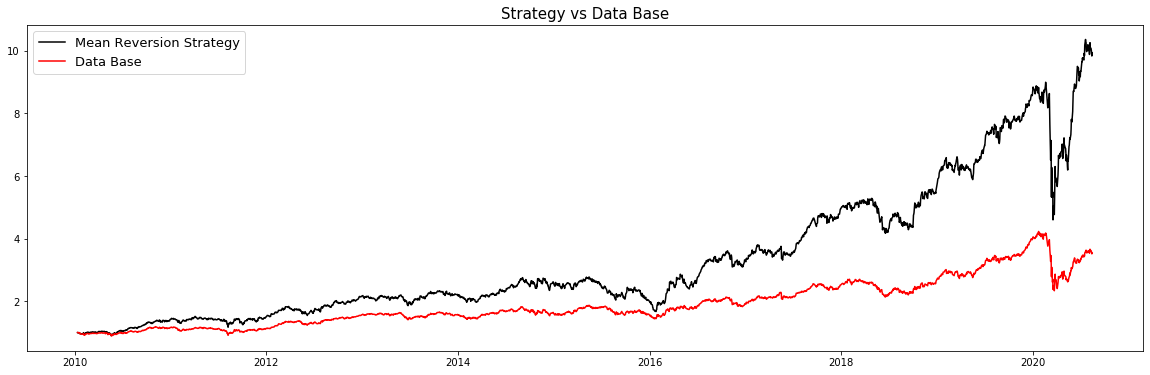

In [69]:
plt.figure(figsize=(20,6))
plt.plot(strategy_meanreversion_daily_performance,label='Mean Reversion Strategy',color='black')
plt.plot(data_base_daily_performance,label='Data Base',color='red')
plt.title('Strategy vs Data Base',fontsize=15)
plt.legend(fontsize=13)
plt.show()